In [135]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

### Load the 'business' dataset

In [44]:
df2 = pd.read_json("yelp_academic_dataset_business.json", chunksize = 1000, lines = True)
drop_cols = ['address', 'state', 'postal_code', 'latitude', 'longitude', 'stars', 'review_count', 'is_open','attributes', 'hours']

* Deleting non useful columns

In [45]:
import time
start = time.time()
chunks = []
a = 0
for chunk in df2:
    a += 1
    chunk_b = chunk.drop(drop_cols, axis = 1)
    restas = chunk_b[chunk_b['categories'].str.contains('restaurant', case = False, na = False)]
    chunks.append(restas)
restaurants = pd.concat(chunks, ignore_index= True, join='outer')
end = time.time()
elapsed = end-start

In [54]:
restaurants.shape

(63961, 4)

## Load the reviews dataset
* Remember we made the merge to use ONLY restaurants data, because there were data from other things

In [55]:
reviews_raw = pd.read_json("yelp_academic_dataset_review.json", chunksize=100000, lines = True)
drop_cols = ['review_id', 'user_id','useful', 'funny', 'cool', 'date']

* Using merge instead of join because we want to join in another column other than the index

In [56]:
a = 0
for chunk in reviews_raw:
    a += 1
    reviews = chunk.drop(drop_cols, axis = 1)
    data = restaurants.merge(reviews, left_on = 'business_id', right_on = 'business_id',how = 'inner')
    if a == 1:
        break

### Finally the data to be preprocessed (the "text" column, to be exact)

In [60]:
data.head()

,business_id,name,city,categories,stars,text
0,pQeaRpvuhoEqudo3uymHIQ,The Empanadas House,Champaign,"Ethnic Food, Food Trucks, Specialty Food, Impo...",5,I love the empanadas from the Empanadas House!...
1,CsLQLiRoafpJPJSkNX2h5Q,Middle East Deli,Charlotte,"Food, Restaurants, Grocery, Middle Eastern",3,"Definitely under new management, and the dinin..."
2,CsLQLiRoafpJPJSkNX2h5Q,Middle East Deli,Charlotte,"Food, Restaurants, Grocery, Middle Eastern",3,I will also agree that this place has great fo...
3,lu7vtrp_bE9PnxWfA8g4Pg,Banzai Sushi,Thornhill,"Japanese, Fast Food, Food Court, Restaurants",4,Been coming here since I was in grade 9 so abo...
4,vjTVxnsQEZ34XjYNS-XUpA,Wetzel's Pretzels,Phoenix,"Food, Pretzels, Bakeries, Fast Food, Restaurants",5,Love Wetzel's pretzels! I always get them when...


## Get a toyset to work in trials from here

In [137]:
data2 = data.loc[0:99, ['name', 'stars', 'text']]

,name,stars,text
0,The Empanadas House,5,I love the empanadas from the Empanadas House!...
1,Middle East Deli,3,"Definitely under new management, and the dinin..."
2,Middle East Deli,3,I will also agree that this place has great fo...
3,Banzai Sushi,4,Been coming here since I was in grade 9 so abo...
4,Wetzel's Pretzels,5,Love Wetzel's pretzels! I always get them when...


* Some graphs to know the number of reviews by ranking

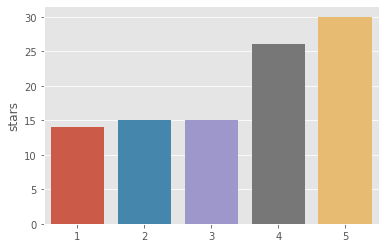

In [136]:
bars = data2['stars'].value_counts()
sns.barplot(x = bars.index, y = bars)

* Delete the number 3's

In [109]:
data2.drop(data2[data2['stars'] == 3].index, inplace = True)
data2 = data2.reset_index(drop = True)

,name,stars,text
0,The Empanadas House,5,I love the empanadas from the Empanadas House!...
1,Banzai Sushi,4,Been coming here since I was in grade 9 so abo...
2,Wetzel's Pretzels,5,Love Wetzel's pretzels! I always get them when...
3,Carl's Jr,5,So why would I be giving a Fast Food chain loc...
4,Carl's Jr,2,I come here bout 3x's a mo. & I just can't do ...
...,...,...,...
80,Papaya Thai,1,"The owner, ""V"", does not pay employees on time..."
81,Papaya Thai,2,"I would give this 3 stars, but I really couldn..."
82,L'Artisan Piadineria,4,I was looking forward to trying this place.\n\...
83,L'Artisan Piadineria,4,Je vais devoir y revenir! Petit café sympa ave...


* We want just the reviews with 4-5 to be positive and the 1-2 to be negative, we do that on the following

In [146]:
data2['Sentiment'] = data2['stars'].apply(lambda x: 1 if x > 3 else 0)

In [147]:
data2.dtypes

name         object
stars         int64
text         object
Sentiment     int64
dtype: object

In [150]:
data2['Sentiment'].value_counts()

1    56
0    44
Name: Sentiment, dtype: int64

## From here start the NLP pipeline